In [34]:
import os
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pathlib import Path

import torch
import torch.nn as nn

import torchviz
import torchinfo

from torch.utils.data import DataLoader
from torchvision import datasets, models, utils, io
from torchvision.transforms import v2  #  New transforms
from torch.optim.lr_scheduler import OneCycleLR  # Transfer learning
from torch.amp import GradScaler, autocast # Mixed precision training

**Initialization**

In [35]:
# Init

# Seed: For reproducibility
rng_seed = 42
random.seed(rng_seed)  
torch.manual_seed(rng_seed)
torch.cuda.manual_seed_all(rng_seed)  # GPUs

print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():

    torch.cuda.empty_cache()  # Clean start

# Workaround for numerical instability when using Mixed Precision
#  - Note: mainly affects RTX 30/40-series GPUs
torch.backends.cuda.matmul.allow_tf32 = True  # Use TF32 for matmuls (faster; error prevention)
torch.backends.cudnn.benchmark = True # cuDNN auto-tuner: best algorithm for hardware   

# Split: Train/Val/Test ratio
train_split_ratio = 0.7
val_split_ratio = 0.15
test_split_ratio = 0.15

# Mode: ResNet variant
model_variant = 'resnet18'  # Relevant, available ResNet models: 'resnet18', 'resnet34', 'resnet50'

# Hyperparameters
num_epochs = 90
batch_size = 32
num_workers = 8

# Early Stopping: Ensure no overfitting / Save training time / Best checkpoint available
best_val_loss = float('inf')
recovery_opp = 5  # "Patience": Oppurtunity for potential improvement
recovery_iter_count = 0
use_early_stopping = False

# Modify ResNet model architecture to better suit EuroSAT data dimensions (64x64 images)
use_architectural_mod = True

# Label smoothing
label_smoothing = 0.1  # 0.0 -> no smoothing (default); 0.1 (typical value)

lr_approach = 'sota'  # 'fixed' or 'sota'

# FIXED: Default

learning_rate = 0.0025  # Default LR
    
# SOTA: Transfer learning

## Different LR for backbone/classifier (pre-trained ResNet model)
backbone_param_lr = 5e-4  # Convolutional layers know about generic features -> lower LR
classifier_param_lr = 5e-3  # Learn new classiciation task -> higher LR
weight_decay = 0.01
warm_up_ratio = 0.3 # 0.2

## OneCycleLR specific parameters
max_lr = [backbone_param_lr, classifier_param_lr]
pct_start = 0.3 # 0.2  # "Warm-up" ratio (phase percentage)
div_factor = 25.0  # Initial LR (max_lr/div_factor)
final_div_factor = 1e4  # Final LR
anneal_strategy = 'cos'  # Cosine annealing -> smoother (default: 'linear')


CUDA available: True


**Pathing and Pre-Processing**



In [36]:
# Pathing
data_root = Path('../data')
data_dir = data_root / 'raw' / 'eurosat'

print(f"Raw source dataset:\n {data_dir}\n")

# Processed Data

processed_data_dir = data_root / 'processed' / 'eurosat'
sample_data_dir = data_root / 'samples' / 'eurosat'

if processed_data_dir.exists():

    print("Note:\n (!) Found existing processed data directory. Removing it...\n") 
    shutil.rmtree(processed_data_dir)

processed_data_dir.mkdir(parents=True, exist_ok=True)

train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

train_dir.mkdir(parents=True, exist_ok=True)
val_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

print("Split Directories:")
print(f" 'Train': {train_dir}")
print(f" 'Val': {val_dir}")
print(f" 'Test': {test_dir}\n")

# Train/Val/Test Split

print("Processing Label Class Data:")

for class_dir in data_dir.iterdir():

    print(f" '{os.path.basename(class_dir)}' ({class_dir})")

    if class_dir.is_dir():

        class_name = class_dir.name

        # Get images in respective class directory
        images = list(class_dir.glob('*.*'))  # EuroSAT file format: *.jpg

        # Shuffle images for random split
        random.shuffle(images)  

        # Split

        train_split_index = int(train_split_ratio * len(images))
        val_split_index = int((train_split_ratio + val_split_ratio) * len(images))

        train_images = images[:(train_split_index)]
        val_images = images[(train_split_index):(val_split_index)]
        test_images = images[(val_split_index):]

        # Respective class directories
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (val_dir / class_name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_name).mkdir(parents=True, exist_ok=True)

        # Move images
        for image in train_images:

            shutil.copy(image, train_dir / class_name / image.name)

        for image in val_images:

            shutil.copy(image, val_dir / class_name / image.name)

        for image in test_images:

            shutil.copy(image, test_dir / class_name / image.name)

print(f"\nData Pre-Processing Steps Completed:\n Train ({100*train_split_ratio:.0f}%) / Val ({100*val_split_ratio:.0f}%) / Test ({100*test_split_ratio:.0f}%) data split ratio employed.")

Raw source dataset:
 ../data/raw/eurosat

Note:
 (!) Found existing processed data directory. Removing it...

Split Directories:
 'Train': ../data/processed/eurosat/train
 'Val': ../data/processed/eurosat/val
 'Test': ../data/processed/eurosat/test

Processing Label Class Data:
 'SeaLake' (../data/raw/eurosat/SeaLake)
 'Highway' (../data/raw/eurosat/Highway)
 'HerbaceousVegetation' (../data/raw/eurosat/HerbaceousVegetation)
 'PermanentCrop' (../data/raw/eurosat/PermanentCrop)
 'Pasture' (../data/raw/eurosat/Pasture)
 'Forest' (../data/raw/eurosat/Forest)
 'Industrial' (../data/raw/eurosat/Industrial)
 'AnnualCrop' (../data/raw/eurosat/AnnualCrop)
 'Residential' (../data/raw/eurosat/Residential)
 'River' (../data/raw/eurosat/River)

Data Pre-Processing Steps Completed:
 Train (70%) / Val (15%) / Test (15%) data split ratio employed.


**Data Sampling for Visualization**

In [37]:
if sample_data_dir.exists():

    print("Note:\n (!) Found existing sample data directory. Removing it...\n")
    shutil.rmtree(sample_data_dir)

sample_data_dir.mkdir(parents=True, exist_ok=True)

print("Respective class samples:")

for class_dir in train_dir.iterdir():

    if class_dir.is_dir():

        class_dir_images = list(class_dir.glob('*.*'))
        random.shuffle(class_dir_images)
        sample_image = class_dir_images[0]
        print(f" '{os.path.basename(class_dir)}': {sample_image}")
        shutil.copy(sample_image, sample_data_dir / sample_image.name)

Note:
 (!) Found existing sample data directory. Removing it...

Respective class samples:
 'SeaLake': ../data/processed/eurosat/train/SeaLake/17893.jpg
 'Highway': ../data/processed/eurosat/train/Highway/20039.jpg
 'HerbaceousVegetation': ../data/processed/eurosat/train/HerbaceousVegetation/18020.jpg
 'PermanentCrop': ../data/processed/eurosat/train/PermanentCrop/04298.jpg
 'Pasture': ../data/processed/eurosat/train/Pasture/07665.jpg
 'Forest': ../data/processed/eurosat/train/Forest/19085.jpg
 'Industrial': ../data/processed/eurosat/train/Industrial/05081.jpg
 'AnnualCrop': ../data/processed/eurosat/train/AnnualCrop/05487.jpg
 'Residential': ../data/processed/eurosat/train/Residential/20401.jpg
 'River': ../data/processed/eurosat/train/River/22374.jpg


**Data Pre-Processing: Transformations (Augmentation) and DataLoaders (PyTorch)**

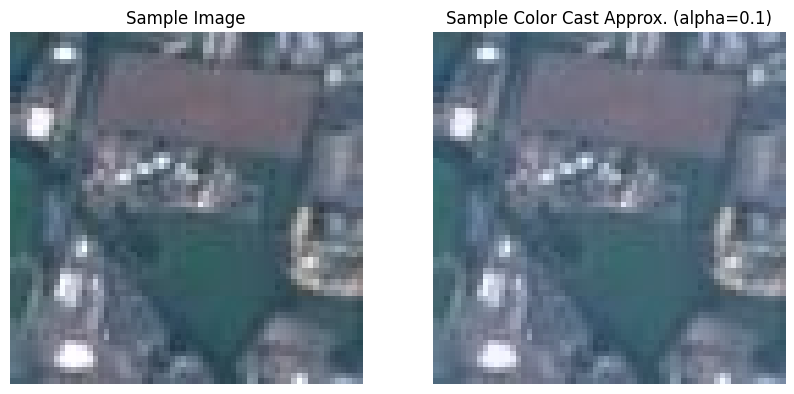

In [38]:
# Definiton of custom augmentation: Color Cast Approximation
def color_cast_approx(img: torch.Tensor, haze_intensity: float = 0.1, fixed_alpha: bool = False) -> torch.Tensor:

    """
    Approximates blueish color cast due to atmospheric effects.
    Reference: Compare with Fig.7 in EuroSAT paper.
    Note: Expected input is float32 tensor in [0, 1] range.
    """

    if img.dtype == torch.uint8:

        sample = img.to(torch.float32) / 255.0

    elif img.dtype == torch.float32:

        sample = img

    else:

        raise TypeError(f"Unsupported input dtype: {img.dtype}. Expected torch.uint8 or torch.float32.")

    blue_tint = torch.tensor([0.6, 0.75, 1.0], device=img.device).view(3, 1, 1)  # alt: 0.5, 0.7, 1.0

    if fixed_alpha == True:

        alpha = haze_intensity

    else:
        
        alpha = torch.rand(1, device=img.device) * haze_intensity

    img_hazed = sample * (1 - alpha) + blue_tint * alpha

    # Clamp: Ensure output in valid [0,1] range
    return torch.clamp(img_hazed, 0.0, 1.0)

# Specify maximum alpha value as haze intensity constraint
max_haze = 0.1

# Get sample image for showcasing
sample_img = io.decode_image(random.choice(list(sample_data_dir.glob('*.*'))))
hazed_img = color_cast_approx(sample_img, haze_intensity=max_haze, fixed_alpha=True)

# Display
fig, (sample, hazed) = plt.subplots(1, 2, figsize=(10, 5))
sample.imshow(sample_img.permute(1, 2, 0))
hazed.imshow(hazed_img.permute(1, 2, 0))
sample.axis('off'), hazed.axis('off')
sample.set_title('Sample Image'), hazed.set_title(f'Sample Color Cast Approx. (alpha={max_haze})')
plt.show()

In [39]:
# Anonymous function for random haze application suing the custom transformation
haze_transform = lambda img: color_cast_approx(img, haze_intensity=max_haze)

# Scaling setup to enable cropping of black areas introduced by rotational transformation
# final_dim = 64
# scaling_factor = 1.5  # conservative
# scale_dim = int(final_dim * scaling_factor)

# Transformations (Data Augmentation)
train_transformations = v2.Compose(  # Using `torchvision.transforms.v2` instead of `torchvision.transforms`
    
    # ref: https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

    [

        # (!): `v2.ToTensor()` depreaceatd in "v2" -> use `v2.ToImage()` ... `v2.ToDtype(torch.float32, scale=True)` instead

        v2.ToImage(),  # Convert to PIL Image or Tensor ()

        v2.Resize((64, 64)),  # EurosSAT dimensions

        # v2.Resize((scale_dim, scale_dim), antialias=True),
        # v2.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), antialias=True),

        # Flips: Reasonable orientation variation
        v2.RandomHorizontalFlip(p=0.5),  # default: 0.5
        v2.RandomVerticalFlip(p=0.5),  # default: 0.5

        v2.RandomApply([v2.RandomRotation(90)], p=0.5),  # Rotation: 90° rotations (0:90:270)

        # v2.RandomCrop(size=(final_dim, final_dim)),

        # (!): Theoretically sound; Potential adverse effects (Satellite images)
        # v2.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  
        # v2.gaussian_blur(kernel_size=(5, 9), sigma=(0.1, 1.0)),  # Too much as already very low resolution
        # v2.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), antialias=True),  # Potential robustness to scale/positon variation

        # (!): Placement after geometric transformations and before color transformations
        #   (*) Gemoetric trans. more efficient/stable operating on `uint8` tensors
        #   (*) Color trans. require floating-point tensor in [0, 1] range (`scale=True`)
        v2.ToDtype(torch.float32, scale=True),

        # ColorJitter: TUNE for realistic satallite image examples, i.e. manifesting atmospheric interference
        v2.RandomApply([

            # (Reasoning): Try to approx. image variance due to atmospheric/lighting conditions
            #   (*) Sentinel-2 Satellite (EuroSAT data source): Assume consitent calibration
            v2.ColorJitter(
                
                # Conservative approach
                brightness=0.2,
                contrast=0.2,  
                saturation=0.15,
                # hue=0.02,  # (!!!): Random hue shifts don't represent color casts due to realistic atmospheric effects
            
            )], p=0.5),


        # Custom Color Cast Approximation
        v2.RandomApply([haze_transform], p=0.5),

        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Pre-Trained ImageNet (Standards)

    ]
    
)

val_transformations = v2.Compose(
    
    [

        v2.ToImage(),
        v2.Resize((64, 64)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ]

)

test_transformations = val_transformations

In [40]:
# Load data
training_data = datasets.ImageFolder(train_dir, transform=train_transformations)
val_data = datasets.ImageFolder(val_dir, transform=val_transformations)
test_data = datasets.ImageFolder(test_dir, transform=test_transformations)

# Extract classes from directory structure
num_classes = len(training_data.classes)

# DataLoaders
train_dataloader = DataLoader(
    
    training_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers

)

val_dataloader = DataLoader(
    
    val_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers

)

test_dataloader = DataLoader(
    
    test_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers

)

print(training_data)
print(val_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 18900
    Root location: ../data/processed/eurosat/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 RandomVerticalFlip(p=0.5)
                 RandomApply(    RandomRotation(degrees=[-90.0, 90.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0))
                 ToDtype(scale=True)
                 RandomApply(    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.85, 1.15)))
                 RandomApply(    <function <lambda> at 0x72f30e8abce0>)
                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
           )
Dataset ImageFolder
    Number of datapoints: 4050
    Root location: ../data/processed/eurosat/val
    StandardTransform
Transform: Compose(
                 ToImage()
     

Note:
 Sampled Training Data Visual Spoiler
 (!) Slight visual deviation from raw data not due transfromations expected as we are skipping de-normalization of ImageNet standards.

Transformations:
 - Horizontal/Vertical Flip
 - Rotation: 0° to 90° Interval 
 - ColorJitter: Brightness, Contrast, Saturation
 - Haze: Atmospheric (Blueish) Effect Approximation


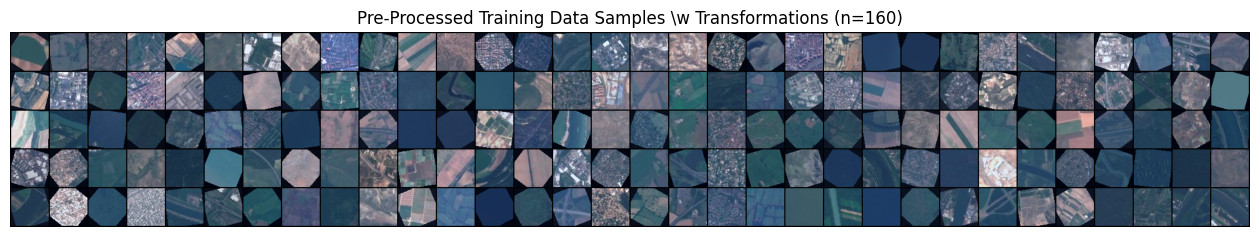

In [41]:
num_samples = 160
samples_per_row = 32

# Access samples at random indices
indices = torch.randperm(len(training_data))[:num_samples]  
samples = [training_data[i][0] for i in indices]  # [0]: image, [1]: label

# Grid: Quick "hacky" approach to enable visual inspection / `scale_each=False`: Sufficient for visual inspection (avoid denormalization step)
grid = utils.make_grid(samples, nrow=samples_per_row, normalize=True, scale_each=False)

print("Note:\n Sampled Training Data Visual Spoiler\n (!) Slight visual deviation from raw data not due transfromations expected as we are skipping de-normalization of ImageNet standards.\n")
print("Transformations:\n - Horizontal/Vertical Flip\n - Rotation: 0° to 90° Interval \n - ColorJitter: Brightness, Contrast, Saturation\n - Haze: Atmospheric (Blueish) Effect Approximation")

plt.figure(figsize=(16, 8))
plt.imshow(grid.permute(1, 2, 0))  # Make `matplotlib` compatible: PyTorch (C, H, W) format --> Expected (H, W, C)
plt.axis('off')
plt.title(f'Pre-Processed Training Data Samples \\w Transformations (n={num_samples})')
plt.show()

**Define Model**

In [42]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}\n")

# Model
try:

    model_constructor = getattr(models, model_variant)

    weights_id = f"ResNet{model_variant[6:]}_Weights"
    weights_constructor = getattr(models, weights_id)
    weights = weights_constructor.DEFAULT

    model = model_constructor(weights=weights)

    print(f"Using Model: Successfully loaded '{model_variant}' model variant and corresponding weights (ImageNet Pre-Training).\n")

except AttributeError:

    print("Using Model: Error! Invalid model spec. Model/Weights not found in torchvision.models.\n")


# CUSTOM MODEL MODIFICATIONS

if use_architectural_mod == True:

    # (!) Change first convolutional layer to 3x3 kernel with stride 1
    #   - Default ResNet (7x7 kernel) is optimized for ImageNet images (224x224)
    #   - Attempt to preserve spatial resolution in low-res (64x64) EuroSAT images
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # (!) Remove initial maxpool layer
    model.maxpool = nn.Identity() 

# (!) Linear data transformation @ Final Layer w.r.t. EuroSAT class count
model.fc = nn.Linear(model.fc.in_features, num_classes)


model = model.to(device)

loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)  # or `criterion`
 
if lr_approach == 'fixed':

    print(f"Using Training Approach: {lr_approach}")

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Default Adam optimizer
    
elif lr_approach == 'sota':

    print(f"Using Training Approach: {lr_approach}")

    # backbone_params = [param for name, param in model.named_parameters() if "fc" not in name and param.requires_grad]
    # classifier_params = [param for name, param in model.named_parameters() if "fc" in name and param.requires_grad]

    # More precise
    backbone_params = []
    classifier_params = []
    
    for name, param in model.named_parameters():

        if not param.requires_grad:

            continue

        if "fc" in name or "classifier" in name:

            classifier_params.append(param)

        else:

            backbone_params.append(param)

    optimizer = torch.optim.AdamW(  # Improved AdamW optimizer: Recommended for transfer learning

        [  

            {'params': backbone_params, 'lr': backbone_param_lr}, # Lower LR for the backbone
            {'params': classifier_params, 'lr': classifier_param_lr},  # Higher LR for the new classifier

        ], weight_decay=weight_decay
        
    )

    scheduler = OneCycleLR(

        optimizer,
        max_lr=max_lr, # Maximum LRs (backbone, classifier)
        steps_per_epoch=int(len(train_dataloader)),
        epochs=num_epochs,
        pct_start=pct_start,  # "Warming Up" phase
        div_factor=div_factor,  # Initial LR (max_lr/div_factor)
        final_div_factor=final_div_factor,  # Final LR
        anneal_strategy=anneal_strategy,  # Cosine annealing smoother (default: 'linear')

    )   

Using Device: cuda

Using Model: Successfully loaded 'resnet18' model variant and corresponding weights (ImageNet Pre-Training).

Using Training Approach: sota


**Model Architecture Information & Visualization**

In [43]:
# # Graph: TorchViz

# ## Trace graph
# batch_sample = next(iter(train_dataloader))  # Single example batch
# input_sample = batch_sample[0]  # [0]: Raw image data 
# y = model(input_sample.to(device))  # Forward pass to trace

# ## Render and output to PDF
# architecture_id = model_variant + "_architecture"
# format = "png"

# graph = torchviz.make_dot(y, params=dict(model.named_parameters()))  # `params` links parameters to nodes
# graph.render(architecture_id, format=format, cleanup=True)

# print(f"Rendered model graph saved to {format}. Too large for inline display: Please review the PDF.\n")

# Print: Simple
print("Model Summary:\n")
print(model)

# Clean Table: TorchInfo
model_stats = torchinfo.summary(
    
        model, 
        input_size = (batch_size, 3, 64, 64), 
        col_names = ["input_size", "output_size", "kernel_size", "num_params"],  # "mult_adds"
        verbose = 0,  # 0: quiet / Jupyter default , 1: default, 2: full detail
        row_settings = ["var_names"],
        depth = 3,
        
)

model_stats

Model Summary:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), 

Layer (type (var_name))                  Input Shape               Output Shape              Kernel Shape              Param #
ResNet (ResNet)                          [32, 3, 64, 64]           [32, 10]                  --                        --
├─Conv2d (conv1)                         [32, 3, 64, 64]           [32, 64, 64, 64]          [3, 3]                    1,728
├─BatchNorm2d (bn1)                      [32, 64, 64, 64]          [32, 64, 64, 64]          --                        128
├─ReLU (relu)                            [32, 64, 64, 64]          [32, 64, 64, 64]          --                        --
├─Identity (maxpool)                     [32, 64, 64, 64]          [32, 64, 64, 64]          --                        --
├─Sequential (layer1)                    [32, 64, 64, 64]          [32, 64, 64, 64]          --                        --
│    └─BasicBlock (0)                    [32, 64, 64, 64]          [32, 64, 64, 64]          --                        --
│    │    └─Con

**Training**

In [44]:
# Pre-Allocation

train_losses = []; val_losses = []
epochs_list = []; epoch_durations = []

# LR tracking
lr_history = []

# Initialize gradient scaler
scaler = GradScaler()

# Training loop
for epoch in range(num_epochs):

    print(f"epoch {epoch + 1}\n-------------------------------")

    train_size = len(train_dataloader.dataset)

    # TRAIN

    model.train()  # Initialize "Training Mode"

    t_epoch_start = time.time()

    cml_train_loss = 0.0  # Cumulation for subsequent mean calcualation
    loss_prev = 0.0

    train_batches = 0
    train_total = 0
    train_correct = 0
    
    for batch, (img, lbl) in enumerate(train_dataloader):
        
        # Training on device (GPU/CUDA if available)
        img = img.to(device)
        lbl = lbl.to(device)

        optimizer.zero_grad(set_to_none=True)  # None instead of zero slightly more efficient
 
        # Forward pass
        with autocast(device_type='cuda', dtype=torch.float16):  # Mixed Precision

            p = model(img)  # Forward pass
            loss = loss_fn(p, lbl)  # Prediction loss

        # Backprop
        # loss.backward()
        scaler.scale(loss).backward()  # Scaled (Mixed Precision)

        # Gradient Clipping: Enhance loss stability (high learning rate phase)
        if lr_approach == 'sota':

            scaler.unscale_(optimizer)  # Unscale gradients before clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 

        # optimizer.step()
        scaler.step(optimizer)

        scaler.update()

        # Up date LR if using SOTA approach
        if lr_approach == 'sota':

            scheduler.step()

            current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]
            lr_history.append(current_lrs)

        # Accumulate loss
        cml_train_loss += loss.item()
        train_batches += 1

        # Loss logging
        if (batch % 100) == 0 and batch > 0:

            loss = loss.item()

            current_sample_abs = batch * batch_size + len(img)
            current_sample_pct = abs(current_sample_abs / train_size) * 100

            # Compute incremental loss difference
            delta_loss = (loss_prev - loss) # if batch > 0 else 0.0  # Handle first batch
            loss_prev = loss

            print(f"sample: {current_sample_abs:>5d}/{train_size:>5d} ({current_sample_pct:>0.2f}%) | loss: {loss:>7f} | delta_loss: {delta_loss:>7f}")
        
        # Track training accuracy metrics
        _, predicted = p.max(1)
        train_total += lbl.size(0)
        train_correct += predicted.eq(lbl).sum().item()

    # Average train loss (epoch)
    avg_train_loss = cml_train_loss / train_batches
    train_losses.append(avg_train_loss)

    # Compute training accuracy
    model_train_accuracy = 100 * (train_correct / train_total)

    # VAL

    model.eval()  # Initialize "Evaluation Mode"
    
    val_size = len(val_dataloader.dataset)
    batch_count = len(val_dataloader)

    cml_val_loss = 0.0
    correct_val_predictions = 0

    with torch.no_grad():  # Avoid gradient unnecessary computation in eval mode

        for img, lbl in val_dataloader:

            img = img.to(device)
            lbl = lbl.to(device)  

            p = model(img)
            loss = loss_fn(p, lbl)

            cml_val_loss += loss.item()
            correct_val_predictions += (p.argmax(1) == lbl).type(torch.float).sum().item()

    # Average validation loss (epoch)
    avg_val_loss = cml_val_loss / batch_count 
    val_losses.append(avg_val_loss)

    model_val_accuracy = 100*(correct_val_predictions / val_size)

    epochs_list.append(epoch + 1)

    t_epoch_end = time.time()
    t_epoch_duration = t_epoch_end - t_epoch_start
    epoch_durations.append(t_epoch_duration)

    print(f"\n")
    print(f"mean train loss: {avg_train_loss:>8f} | train accuracy: {model_train_accuracy:>0.2f}%")
    print(f"mean val loss:   {avg_val_loss:>8f} | val accuracy:   {model_val_accuracy:>0.2f}%\n")
    print(f"epoch time: {t_epoch_duration:>0.1f}s\n")

    # EARLY STOPPING

    if best_val_loss > avg_val_loss:

        recovery_iter_count = 0  # Reset counter

        best_val_loss = avg_val_loss
        
        # Save corresponding model checkpoint
        torch.save({

            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_accuracy': model_val_accuracy,

        }, '../results/models/best_model_checkpoint.pth')

        print(f"new best: saved weight checkpoint corresponding to current validation loss: {avg_val_loss:.4f}\n")

    else:

        recovery_iter_count += 1  # Increase counter

        if recovery_iter_count >= recovery_opp and use_early_stopping == True:

                print(f"(!) Early Stopping: No improvement in validation loss for {recovery_opp} consecutive epochs. Terminating training.\n")
            
                break

total_training_time = sum(epoch_durations)

print(f"Training Done! Total training duration for {num_epochs} epochs: {total_training_time:>0.1f}s")

epoch 1
-------------------------------
sample:  3232/18900 (17.10%) | loss: 1.100113 | delta_loss: -1.100113
sample:  6432/18900 (34.03%) | loss: 1.194053 | delta_loss: -0.093940
sample:  9632/18900 (50.96%) | loss: 0.921276 | delta_loss: 0.272776
sample: 12832/18900 (67.89%) | loss: 0.937596 | delta_loss: -0.016320
sample: 16032/18900 (84.83%) | loss: 0.783261 | delta_loss: 0.154334


mean train loss: 1.054213 | train accuracy: 76.75%
mean val loss:   0.751064 | val accuracy:   90.64%

epoch time: 15.2s

new best: saved weight checkpoint corresponding to current validation loss: 0.7511

epoch 2
-------------------------------
sample:  3232/18900 (17.10%) | loss: 0.790634 | delta_loss: -0.790634
sample:  6432/18900 (34.03%) | loss: 0.765443 | delta_loss: 0.025191
sample:  9632/18900 (50.96%) | loss: 0.954457 | delta_loss: -0.189014
sample: 12832/18900 (67.89%) | loss: 0.660434 | delta_loss: 0.294024
sample: 16032/18900 (84.83%) | loss: 0.697129 | delta_loss: -0.036696


mean train los

**Save Last Checkpoint: Final Model**

In [45]:
# Final model checkpoint
model_checkpoint = {

    'epoch': num_epochs,

    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),

    'train_losses': train_losses,
    'val_losses': val_losses,
    'final_accuracy': model_val_accuracy,

    'hyperparameters': {

        'lr_approach': lr_approach,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'backbone_lr': backbone_param_lr,
        'classifier_lr': classifier_param_lr,

    }
    
}

# Output: PyTorch state dictionary
torch.save(model_checkpoint, '../results/models/final_model_checkpoint.pth')

**Evaluation Metrics and Visualization**

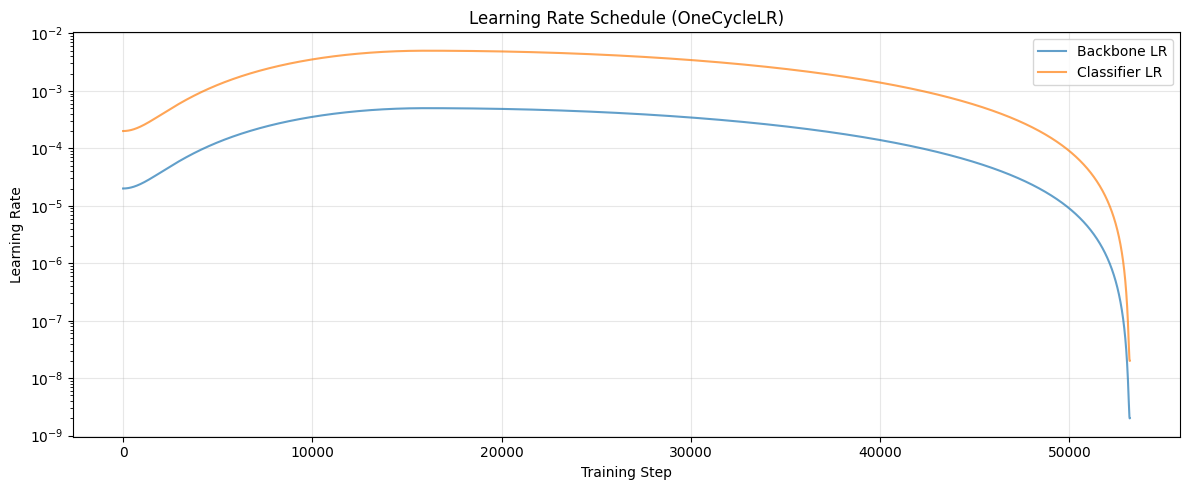

In [46]:
lr_array = np.array(lr_history)

plt.figure(figsize=(12, 5))

plt.plot(lr_array[:, 0], label='Backbone LR', alpha=0.7)
plt.plot(lr_array[:, 1], label='Classifier LR', alpha=0.7)

plt.yscale('log')

plt.title('Learning Rate Schedule (OneCycleLR)')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')

plt.legend()

plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('../results/figures/lr_schedule.png', dpi=300)

plt.show()

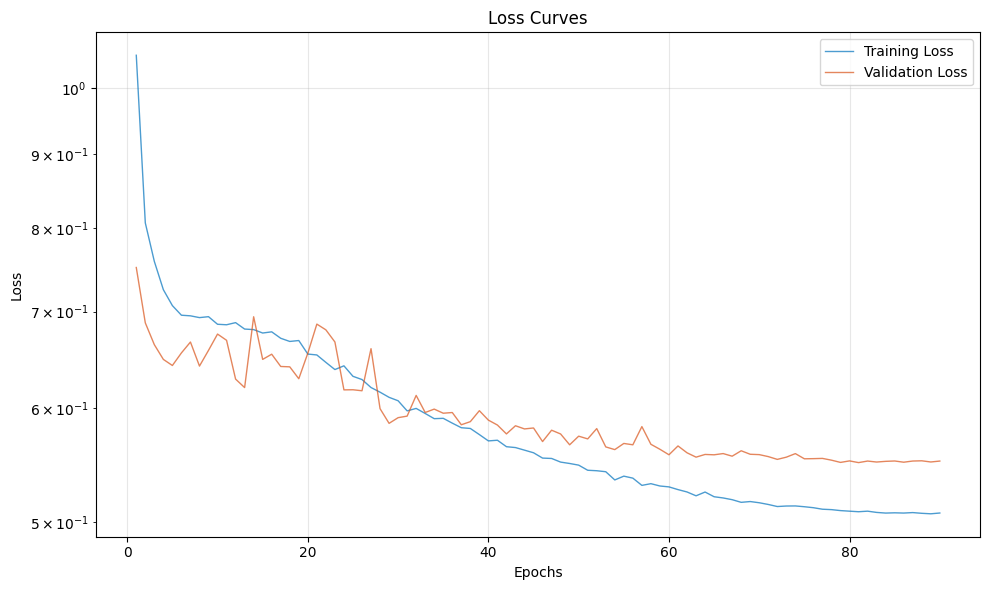

In [47]:
# Loss curves
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, train_losses, '-', color="#0072BD", label='Training Loss', linewidth=1, alpha=0.7)
plt.plot(epochs_list, val_losses, '-', color="#D95319", label='Validation Loss', linewidth=1, alpha=0.7)

plt.yscale('log')

plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('../results/figures/loss_curves.png', dpi=300)

plt.show()

**Confusion Matrices**

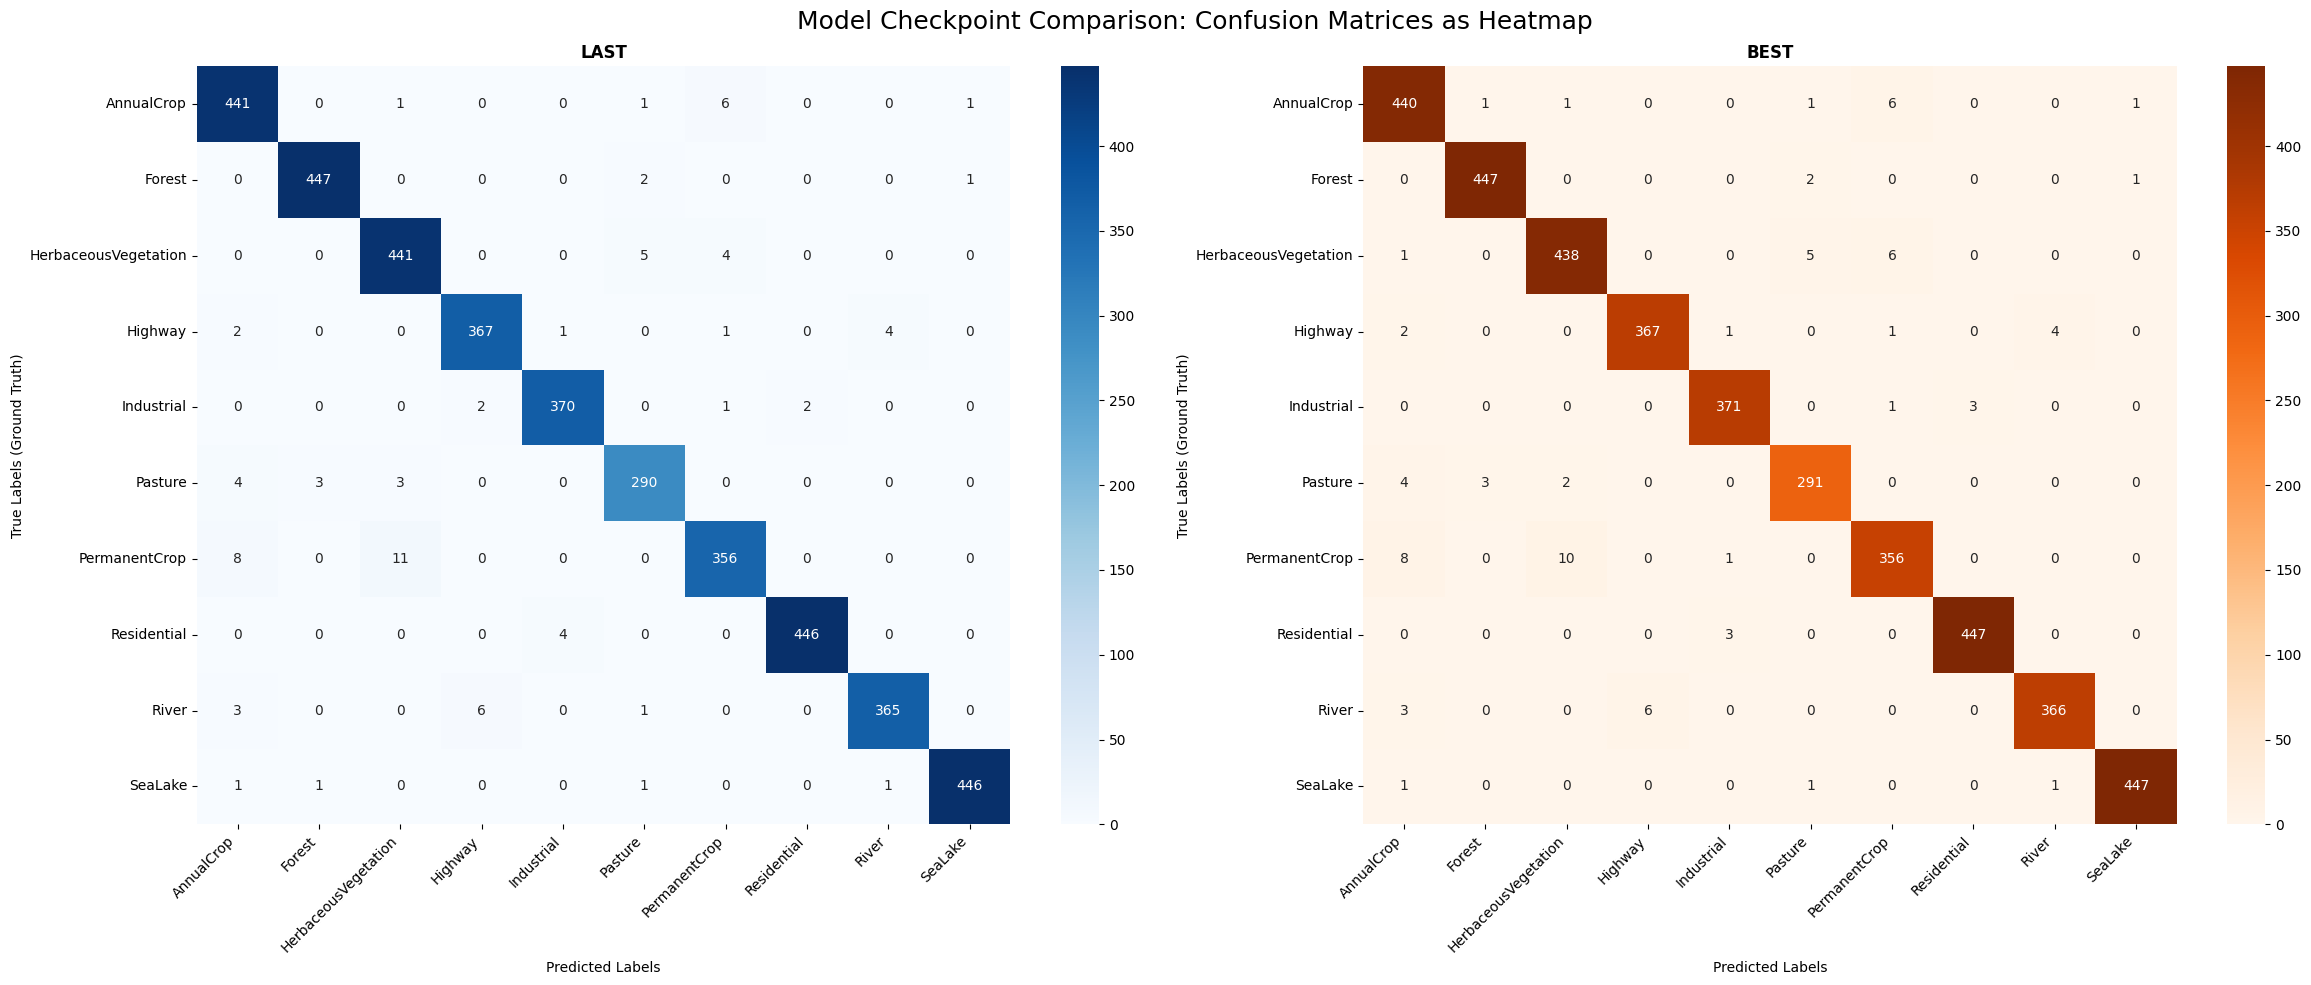

In [48]:

# Evaluation Function
def evaluate_model(model, dataloader, device):

    model.eval()

    all_lbls = []
    all_prds = []

    with torch.no_grad():

        for img, lbl in dataloader:
            
            img = img.to(device)
            
            p = model(img)

            prd = p.argmax(1).cpu().numpy()

            all_lbls.extend(lbl.numpy())
            all_prds.extend(prd)

    return all_lbls, all_prds

# Last Checkpoint
last_ckpt_path = '../results/models/final_model_checkpoint.pth'
last_ckpt = torch.load(last_ckpt_path)
model.load_state_dict(last_ckpt['model_state_dict'])

last_ckpt_lbls, last_ckpt_prds = evaluate_model(model, test_dataloader, device)

# Best Checkpoint
best_ckpt_path = '../results/models/best_model_checkpoint.pth'
best_ckpt = torch.load(best_ckpt_path)
model.load_state_dict(best_ckpt['model_state_dict'])

best_ckpt_lbls, best_ckpt_prds = evaluate_model(model, test_dataloader, device)

# Evaluation
class_names = test_data.classes

# Confusion Matrix
last_ckpt_cm = sklearn.metrics.confusion_matrix(last_ckpt_lbls, last_ckpt_prds)
best_ckpt_cm = sklearn.metrics.confusion_matrix(best_ckpt_lbls, best_ckpt_prds)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Model Checkpoint Comparison: Confusion Matrices as Heatmap', fontsize=18)

sns.heatmap(last_ckpt_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axs[0])
sns.heatmap(best_ckpt_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names, ax=axs[1])

axs[0].set_title('LAST', fontweight='bold')
axs[1].set_title('BEST', fontweight='bold')

# for _, ax in enumerate(fig.axes):  # Most concise approach but attaches labels to Seaborn colorbars
for ax in axs.reshape(-1): 

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels (Ground Truth)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../results/figures/confusion_matrices.png', dpi=300)

plt.show()

**Classification Reports**

In [49]:
print("\n Scikit-Learn Classification Report: Last Model Checkpoint (final) \n")
print(sklearn.metrics.classification_report(last_ckpt_lbls, last_ckpt_prds, target_names=class_names, digits=4))


 Scikit-Learn Classification Report: Last Model Checkpoint (final) 

                      precision    recall  f1-score   support

          AnnualCrop     0.9608    0.9800    0.9703       450
              Forest     0.9911    0.9933    0.9922       450
HerbaceousVegetation     0.9671    0.9800    0.9735       450
             Highway     0.9787    0.9787    0.9787       375
          Industrial     0.9867    0.9867    0.9867       375
             Pasture     0.9667    0.9667    0.9667       300
       PermanentCrop     0.9674    0.9493    0.9583       375
         Residential     0.9955    0.9911    0.9933       450
               River     0.9865    0.9733    0.9799       375
             SeaLake     0.9955    0.9911    0.9933       450

            accuracy                         0.9800      4050
           macro avg     0.9796    0.9790    0.9793      4050
        weighted avg     0.9801    0.9800    0.9800      4050



In [50]:
print("\n Scikit-Learn Classification Report: Best Model Checkpoint (best) \n")
print(sklearn.metrics.classification_report(best_ckpt_lbls, best_ckpt_prds, target_names=class_names, digits=4))


 Scikit-Learn Classification Report: Best Model Checkpoint (best) 

                      precision    recall  f1-score   support

          AnnualCrop     0.9586    0.9778    0.9681       450
              Forest     0.9911    0.9933    0.9922       450
HerbaceousVegetation     0.9712    0.9733    0.9723       450
             Highway     0.9839    0.9787    0.9813       375
          Industrial     0.9867    0.9893    0.9880       375
             Pasture     0.9700    0.9700    0.9700       300
       PermanentCrop     0.9622    0.9493    0.9557       375
         Residential     0.9933    0.9933    0.9933       450
               River     0.9865    0.9760    0.9812       375
             SeaLake     0.9955    0.9933    0.9944       450

            accuracy                         0.9802      4050
           macro avg     0.9799    0.9794    0.9797      4050
        weighted avg     0.9803    0.9802    0.9802      4050

